In [8]:
import torch
import numpy as np

from torch.utils.data import DataLoader
import torch.utils.data as data_utils

from torch.optim import SGD, Adam

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from datasets import get_dataset

from loss_fns import LogisticRegression, NLLSQ
from optimizers import SPS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def run_optimizer(xy_init, optimizer_class, loss_fn, iters, **optimizer_kwargs):

    xy = torch.tensor(xy_init, requires_grad=True)

    # optimizer = SPS([xy], preconditioner="none", slack_method="none")
    optimizer = optimizer_class([xy], **optimizer_kwargs)
    
    path = np.empty((iters + 1, 2))
    for step in range(iters):
            
            def closure():
                optimizer.zero_grad()
                return loss_fn(xy)
            
            loss = closure()

            if isinstance(optimizer, SPS):     
                optimizer.step(closure) 
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            

            path[step, :] = xy.detach().numpy()

    return path

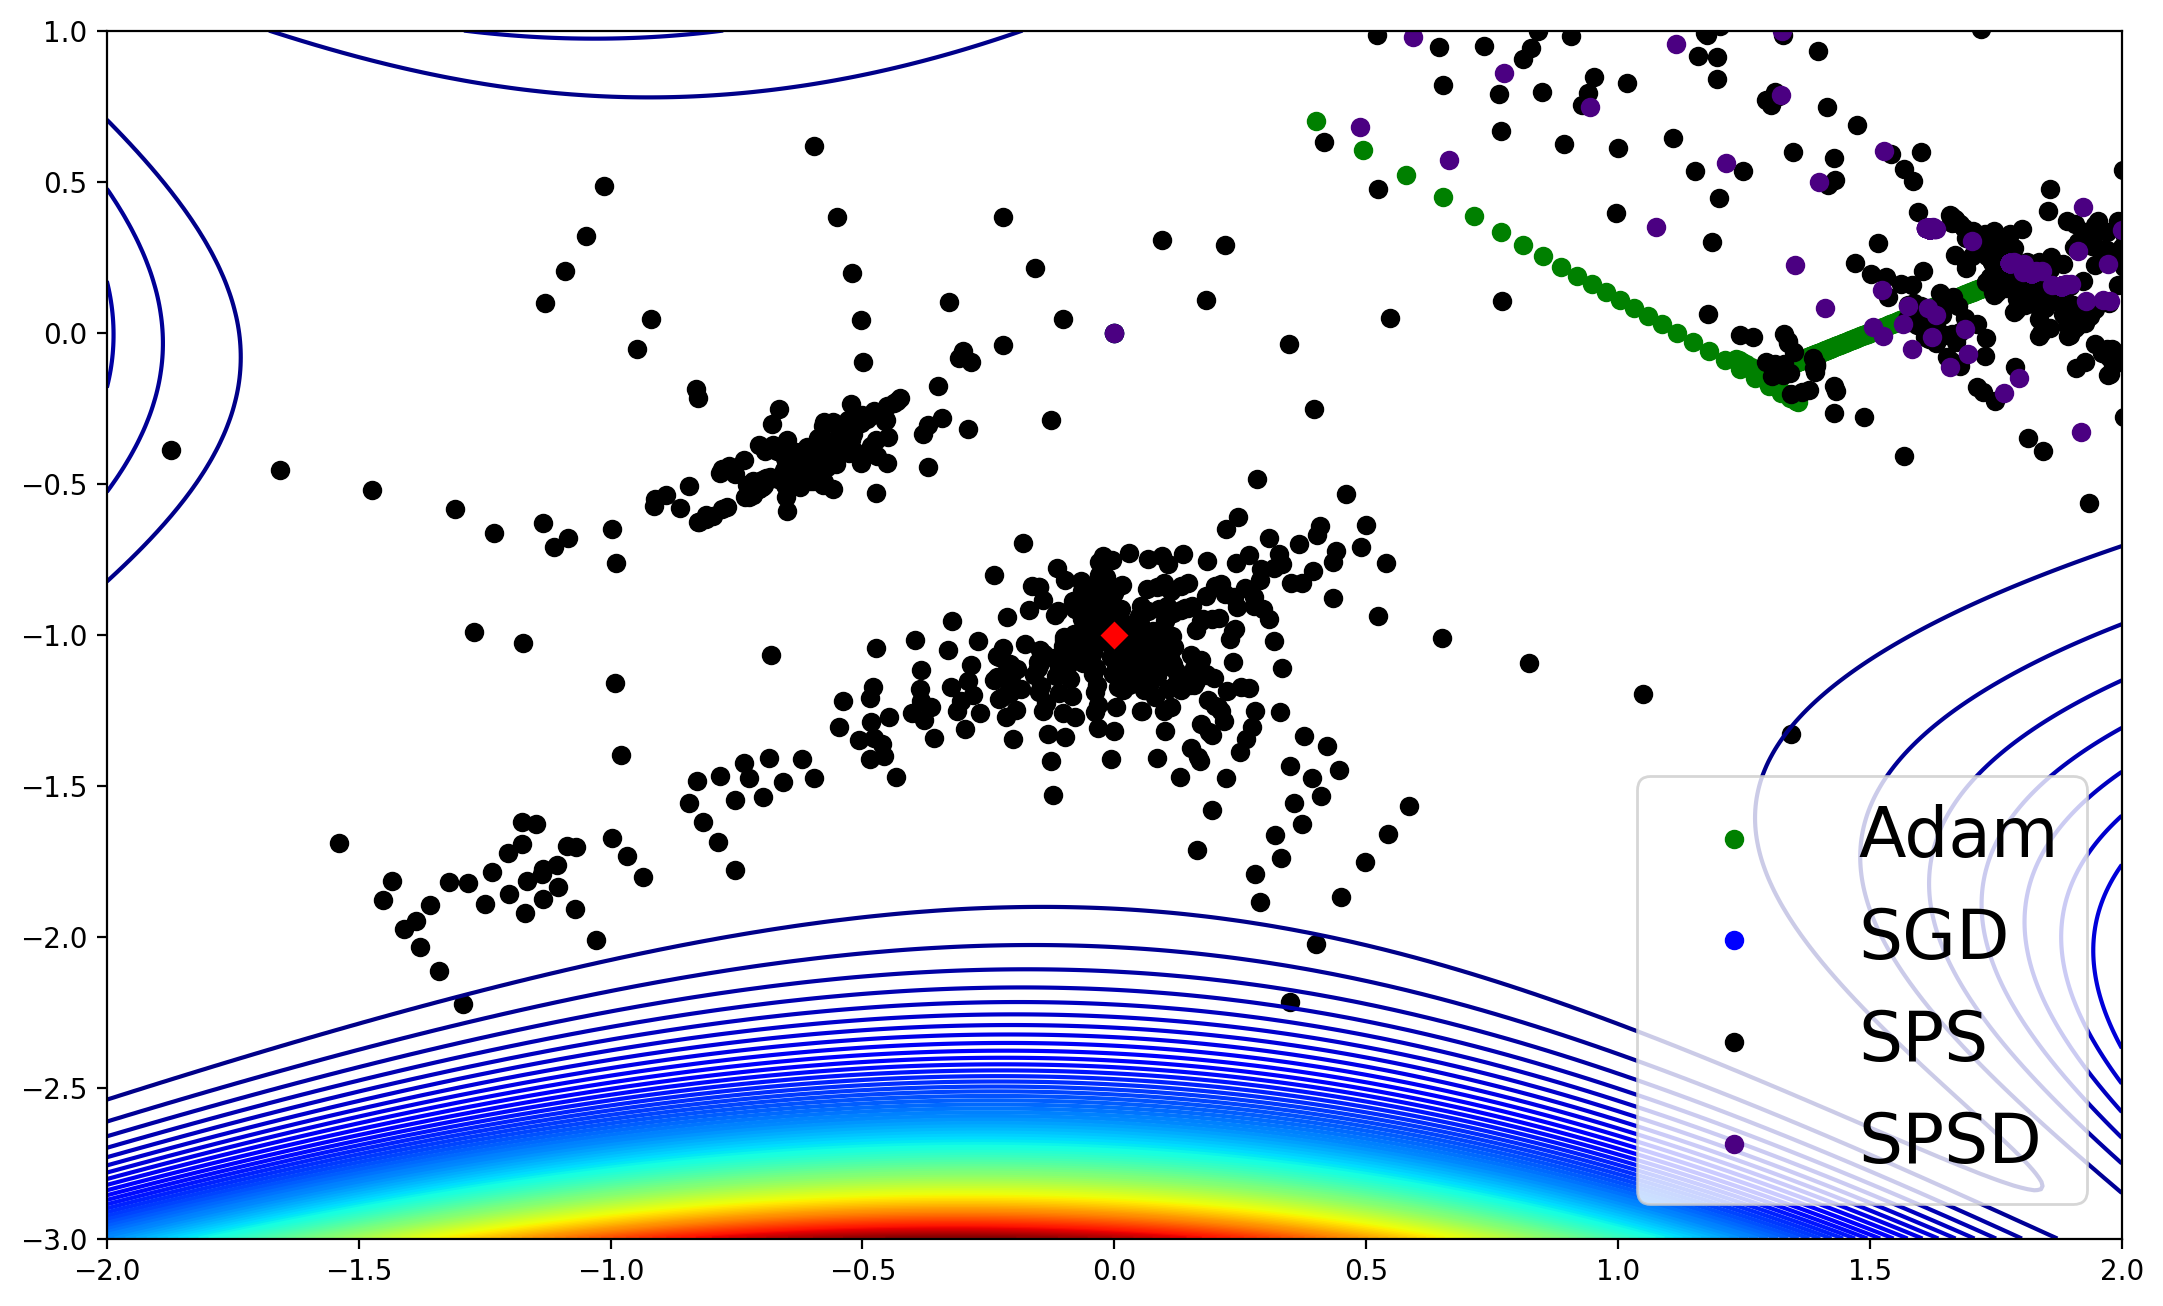

In [10]:
def mccormick(xy):
    x, y = xy
    return np.sin(x + y) + (x - y)**2 - 1.5 * x + 2.5 * y + 1


def rastrigin(xy):
    x, y = xy
    A = 10
    return A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y)) 

def rastrigin_scaled(xy):
    x, y = xy
    A = 10
    return A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y)) 

def GoldsteinPrice(xy):
    x, y = xy
    res = (1 + (x + y + 1)**2*(19 - 14*x+3*x**2- 14*y + 6*x*y + 3*y**2))
    res *= (30 + (2*x - 3*y)**2*(18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return res


from torch.optim import Adam, SGD

# optimizer = SPS([xy], preconditioner="none", slack_method="none")

xy_init = (.3, .8)  
n_iter = 1500

loss_fn = GoldsteinPrice
y_lim = (-3., 1.)
x_lim = (-2., 2.)

path_adam = run_optimizer(xy_init, Adam, loss_fn, n_iter, lr=0.1)
path_sgd = run_optimizer(xy_init, SGD, loss_fn, n_iter, lr=0.1)
path_sps = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="none")
path_sps_d = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="hutch", slack_method="none")


paths = [path_adam, path_sgd, path_sps, path_sps_d]
colors = ["green", "blue", "black", "indigo"]
names = ["Adam", "SGD", "SPS", "SPSD"]


n_points = 300

x = np.linspace(*x_lim, n_points)
y = np.linspace(*y_lim, n_points)
X, Y = np.meshgrid(x, y)
Z = GoldsteinPrice([X, Y])

minimum = (0., -1.)

fig, ax = plt.subplots(figsize=(13, 8), dpi=200)
ax.contour(X, Y, Z, 90, cmap="jet")

scatters = [ax.scatter(None,
                        None,
                        label=label,
                        c=c) for c, label in zip(colors, names)]

for path, scatter in zip(paths, scatters):
        scatter.set_offsets(path)

        # ax.set_title(str(i))


ax.legend(prop={"size": 25})
ax.plot(*minimum, "rD")





In [11]:
def train(criterion_class, train_data, train_target, batch_size, steps, optimizer_class, **optimizer_kwargs):

    params = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    train_load = data_utils.TensorDataset(train_data, train_target)
    train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

    criterion = criterion_class(params)
    optimizer = optimizer_class([params], **optimizer_kwargs)

    train_loss = criterion(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(train_loss, params)

    slack = 0

    hist = [[train_loss.item(), torch.linalg.norm(g).item() ** 2, slack]]
    
    

    for step in range(steps):
        for i, (batch_data, batch_target) in enumerate(train_dataloader):  
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            optimizer.zero_grad()
            
            def closure():
                return criterion(batch_data, batch_target)
            
            loss = closure()

            if isinstance(optimizer, SPS):     
                optimizer.step(closure) 
                slack = optimizer.replay_buffer[-1]["slack"]
            else:
                loss.backward()
                optimizer.step()

        train_loss = criterion(train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(train_loss, params)

        hist.append([train_loss.item(), torch.linalg.norm(g).item() ** 2, slack])
    
        print(f"Loss: {train_loss.item()} | GradNorm^2: {torch.linalg.norm(g).item() ** 2 }")


        

    return hist

In [12]:
def run_regression(loss, dataset_name, batch_size, scale, epochs):

    if dataset_name == "covtype.libsvm.binary.scale" or dataset_name == "covtype.libsvm.binary":
        train_data, train_target = get_dataset(dataset_name, batch_size, 0.05, scale, loss.y_range)
    else:
        train_data, train_target = get_dataset(dataset_name, batch_size, 1.0, scale, loss.y_range) 

    
    assert torch.equal(train_target.unique(), loss.y_range), "Target range must be same as loss target range."
    
    results = dict()    

    sgd = train(
        loss,
        train_data, 
        train_target, 
        batch_size,
        epochs,
        SGD,
        lr=0.01
    )

    sps_l1 = train(
        loss,
        train_data, 
        train_target, 
        batch_size,
        epochs,
        SPS,
        preconditioner="none",
        slack_method="L1"
    )

    sps_l1_d = train(
        loss,
        train_data, 
        train_target, 
        batch_size,
        epochs,
        SPS,
        preconditioner="hutch",
        slack_method="L1"
    )

    sps_l2 = train(
        loss,
        train_data, 
        train_target, 
        batch_size,
        epochs,
        SPS,
        preconditioner="none",
        slack_method="L2"
    )

    sps_l2_d = train(
        loss,
        train_data, 
        train_target, 
        batch_size,
        epochs,
        SPS,
        preconditioner="hutch",
        slack_method="L2"
    )

    results.update({
        "sgd": sgd,
        "sps_l1": sps_l1,
        "sps_l1_d": sps_l1_d,
        "sps_l2": sps_l2,
        "sps_l2_d": sps_l2_d
    })

    return results


def plot_regression(results, save=False, **save_kwargs):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
    ax[0].semilogy([x[0] for x in results["sgd"]])
    ax[0].semilogy([x[0] for x in results["sps_l1"]], "--")
    ax[0].semilogy([x[0] for x in results["sps_l1_d"]], "-.")
    ax[0].semilogy([x[0] for x in results["sps_l2"]])
    ax[0].semilogy([x[0] for x in results["sps_l2_d"]], ":")
    ax[0].set_title("Loss")

    ax[1].semilogy([x[1] for x in results["sgd"]])
    ax[1].semilogy([x[1] for x in results["sps_l1"]], "--")
    ax[1].semilogy([x[1] for x in results["sps_l1_d"]], "-.")
    ax[1].semilogy([x[1] for x in results["sps_l2"]])
    ax[1].semilogy([x[1] for x in results["sps_l2_d"]], ":")
    ax[1].set_title(r"$\|\| \nabla F(W) \|\|^2$")

    ax[2].semilogy([0 for x in results["sgd"]])
    ax[2].semilogy([x[2] for x in results["sps_l1"]], "--")
    ax[2].semilogy([x[2] for x in results["sps_l1_d"]], "-.")
    ax[2].semilogy([x[2] for x in results["sps_l2"]])
    ax[2].semilogy([x[2] for x in results["sps_l2_d"]], ":")
    ax[2].set_title(r"$s$")

    dataset_name = save_kwargs["dataset_name"]
    scale_data = save_kwargs["scale_data"]
    fig.suptitle(f"Dataset: {dataset_name} Scaled: {scale_data}")
    fig.legend(["sgd", "sps_l1", "sps_l1_d", "sps_l2", "sps_l2_d"])

    if save:
        pass
        # fig.savefig(f"plots/2-{dataset_name}_{loss_fn}_scale:{scale_data}.png")

In [ ]:
batch_size = 1
dataset_name = "colon-cancer"
scale_data = False
epochs = 20

results = run_regression(
    LogisticRegression,
    dataset_name,
    batch_size,
    scale_data,
    epochs,
)

In [4]:
batch_size = 256
dataset_name = "covtype.libsvm.binary.scale"
scale_data = False
epochs = 5

results = run_regression(
    NLLSQ,
    dataset_name,
    batch_size,
    scale_data,
    epochs,
)

Loss: 0.2487494796514511 | GradNorm^2: 0.0010675157628275422
Loss: 0.2475622296333313 | GradNorm^2: 0.0010154191065956386
Loss: 0.24643364548683167 | GradNorm^2: 0.0009684060826993385
Loss: 0.24535450339317322 | GradNorm^2: 0.0009245028671549561
Loss: 0.24432356655597687 | GradNorm^2: 0.0008845499275290103
Loss: 0.2485295981168747 | GradNorm^2: 0.001061079905797735


/home/farshed.abdukhakimov/projects/sps2/optimizers.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s - self.lmd + step_size_temp))
/home/farshed.abdukhakimov/projects/sps2/optimizers.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(0.0), torch.tensor(loss - s + self.lmd) ) / (1 + gnorm_square)


Loss: 0.2473594695329666 | GradNorm^2: 0.001008836014019035
Loss: 0.2462477684020996 | GradNorm^2: 0.0009621735285828305
Loss: 0.24519097805023193 | GradNorm^2: 0.0009204593741497652
Loss: 0.2441837340593338 | GradNorm^2: 0.0008824342285472832
Loss: 0.23855912685394287 | GradNorm^2: 0.0007067037751077067
Loss: 0.23197510838508606 | GradNorm^2: 0.000533976820261961
Loss: 0.22698639333248138 | GradNorm^2: 0.0004258965312608533
Loss: 0.2228439301252365 | GradNorm^2: 0.0003464495737204448
Loss: 0.21950025856494904 | GradNorm^2: 0.00029275609621853826
Loss: 0.24936875700950623 | GradNorm^2: 0.0010960693440333902


/home/farshed.abdukhakimov/projects/sps2/optimizers.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step_size = torch.max(torch.tensor(0.0), torch.tensor(loss - self.lmd_hat * s)) / (gnorm_square + self.lmd_hat)


Loss: 0.24906419217586517 | GradNorm^2: 0.001081557503145092
Loss: 0.2487640678882599 | GradNorm^2: 0.001067659148957359
Loss: 0.24846895039081573 | GradNorm^2: 0.0010545495467713245
Loss: 0.2481798678636551 | GradNorm^2: 0.0010421166066996168
Loss: 0.24541744589805603 | GradNorm^2: 0.00094518765848145
Loss: 0.243148535490036 | GradNorm^2: 0.0008397547875511752
Loss: 0.24112924933433533 | GradNorm^2: 0.0007806293111967677
Loss: 0.23931439220905304 | GradNorm^2: 0.0007339226971016105
Loss: 0.2376088947057724 | GradNorm^2: 0.0006872144124678986


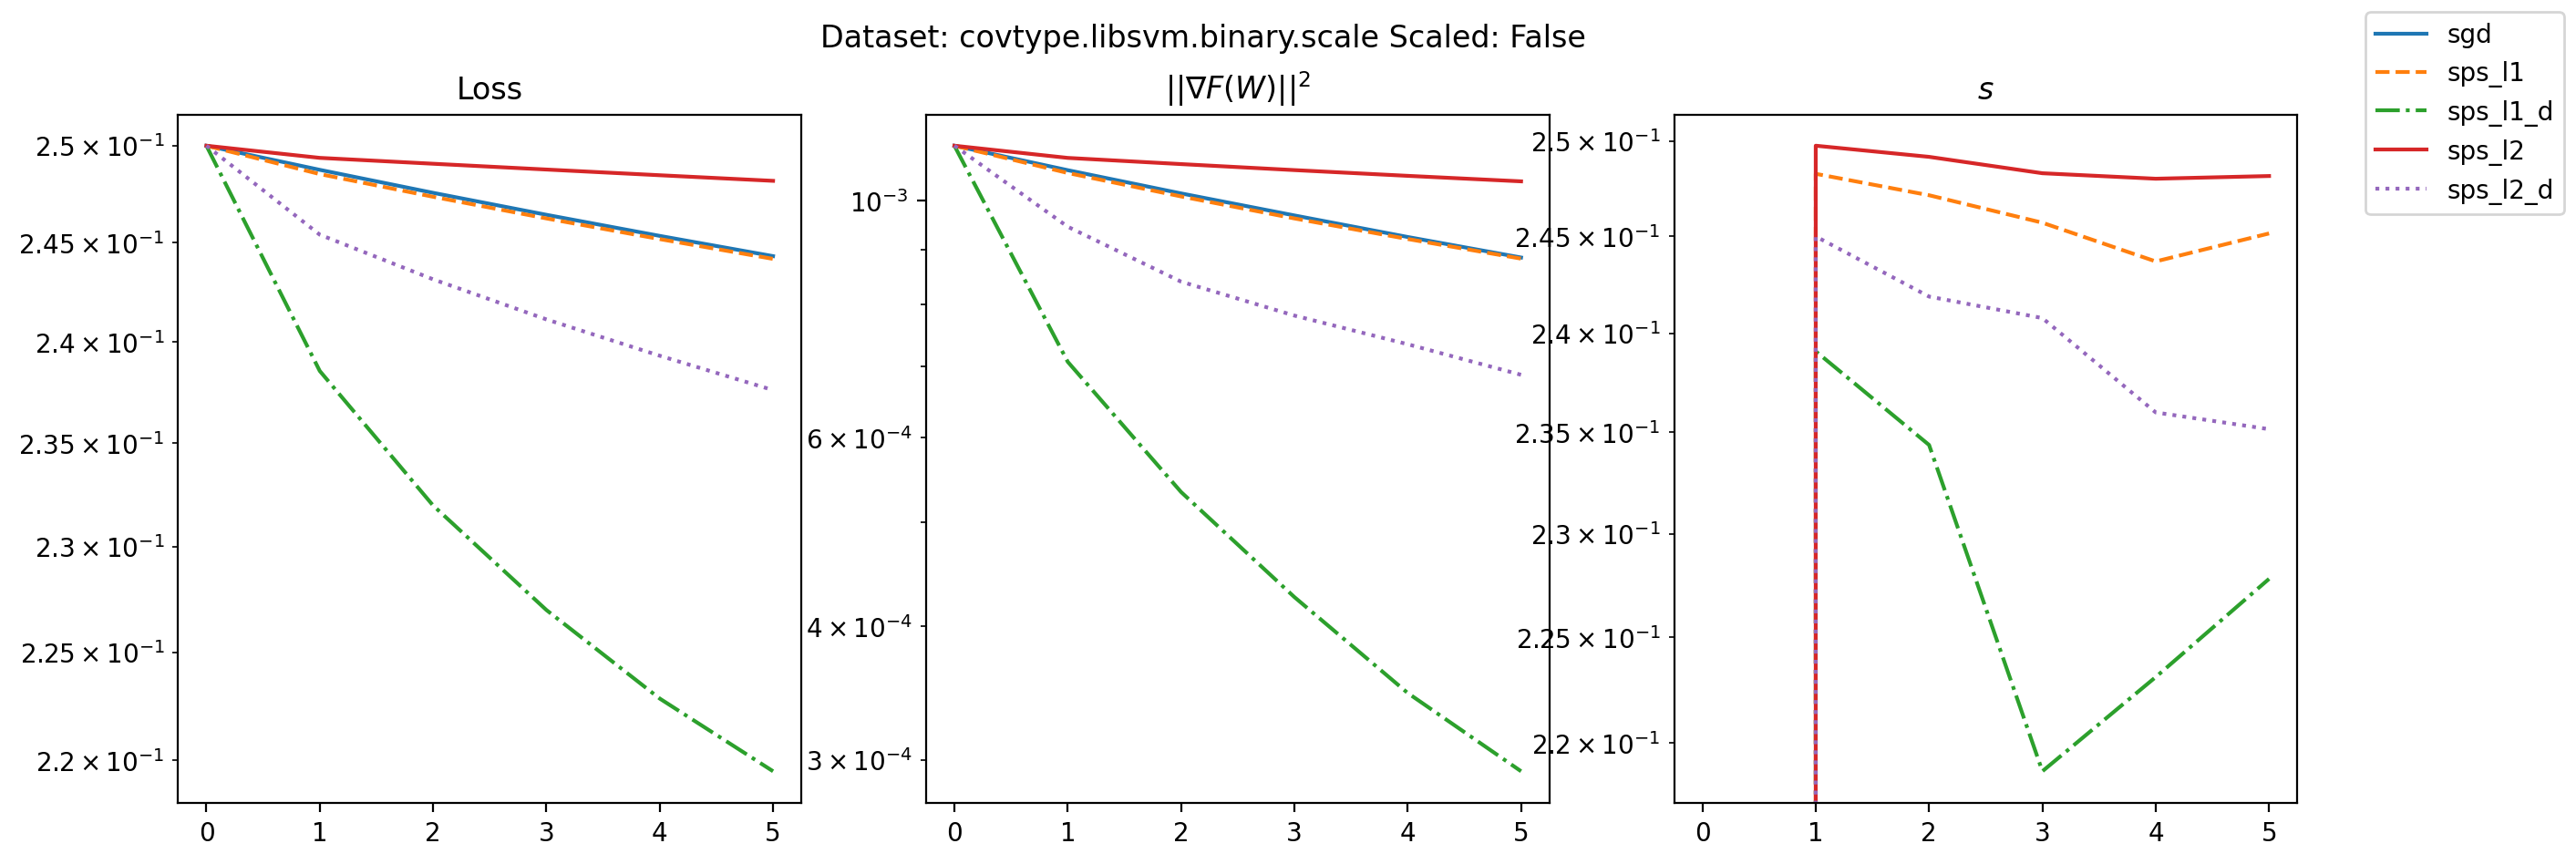

In [5]:
plot_regression(results, save=False, dataset_name=dataset_name, scale_data=scale_data)

In [ ]:
import os

f"results/mushrooms/bs_256/epochs_1000/scaled_True/logreg/sps/lr_0/precond_hutch/slack_l1/seed_0/"
f"results/mushrooms/bs_256/epochs_1000/scaled_False/nllsq/sgd/lr_0.1/precond_none/slack_none/seed_0/"

directory = f"results/{dataset_name}/percen_1.0/scaled_{scale_data}/bs_{batch_size}/epochs_{epochs}/{criterion_class}/{optimizer_class}/lr_{lr}/precond_{preconditioner}/slack_{slack_method}/seed_{seed}/"

if not os.path.exists:
    os.makedirs(directory)

torch.save(results, directory)



python train.py --dataset_name= --percent= --scale_data= --batch_size= --epochs= --loss= --optimizer= --lr== --preconditioner= --slack_method= --seed= 

In [44]:
batch_size = 16
dataset_name = "mushrooms"
scale_data = False

train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)

sgd = train(
    LogisticRegression,
    train_data, 
    train_target, 
    batch_size,
    100,
    SGD,
    lr=0.01
)

Loss: 0.016340913251042366 | GradNorm^2: 0.003021805741179731
Loss: 0.008467230014503002 | GradNorm^2: 0.0007956205777465281
Loss: 0.0057428861036896706 | GradNorm^2: 0.0003619095831772917
Loss: 0.004354253876954317 | GradNorm^2: 0.00020641326377043943
Loss: 0.0035109424497932196 | GradNorm^2: 0.00013339088148947922
Loss: 0.0029441406950354576 | GradNorm^2: 9.334012592069566e-05
Loss: 0.002536406507715583 | GradNorm^2: 6.899307697483606e-05
Loss: 0.0022290009073913097 | GradNorm^2: 5.3095304028652696e-05
Loss: 0.0019886891823261976 | GradNorm^2: 4.213353826632016e-05
Loss: 0.001795723452232778 | GradNorm^2: 3.425938719439983e-05
Loss: 0.0016372440150007606 | GradNorm^2: 2.840893055887448e-05
Loss: 0.0015047513879835606 | GradNorm^2: 2.3943210345059307e-05
Loss: 0.0013923330698162317 | GradNorm^2: 2.045728240889031e-05
Loss: 0.0012957236031070352 | GradNorm^2: 1.768336538855047e-05
Loss: 0.0012117588194087148 | GradNorm^2: 1.5438694061722805e-05
Loss: 0.0011381135554984212 | GradNorm^2:

In [13]:
batch_size = 1
dataset_name = "colon-cancer"
scale_data = False

train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

sps = train(
    w,
    LogisticRegression,
    train_data, 
    train_target, 
    batch_size,
    100,
    SPS,
    preconditioner="none",
    slack_method="none"
)

/home/farshed.abdukhakimov/projects/sps2/datasets


TypeError: train() takes 6 positional arguments but 7 were given

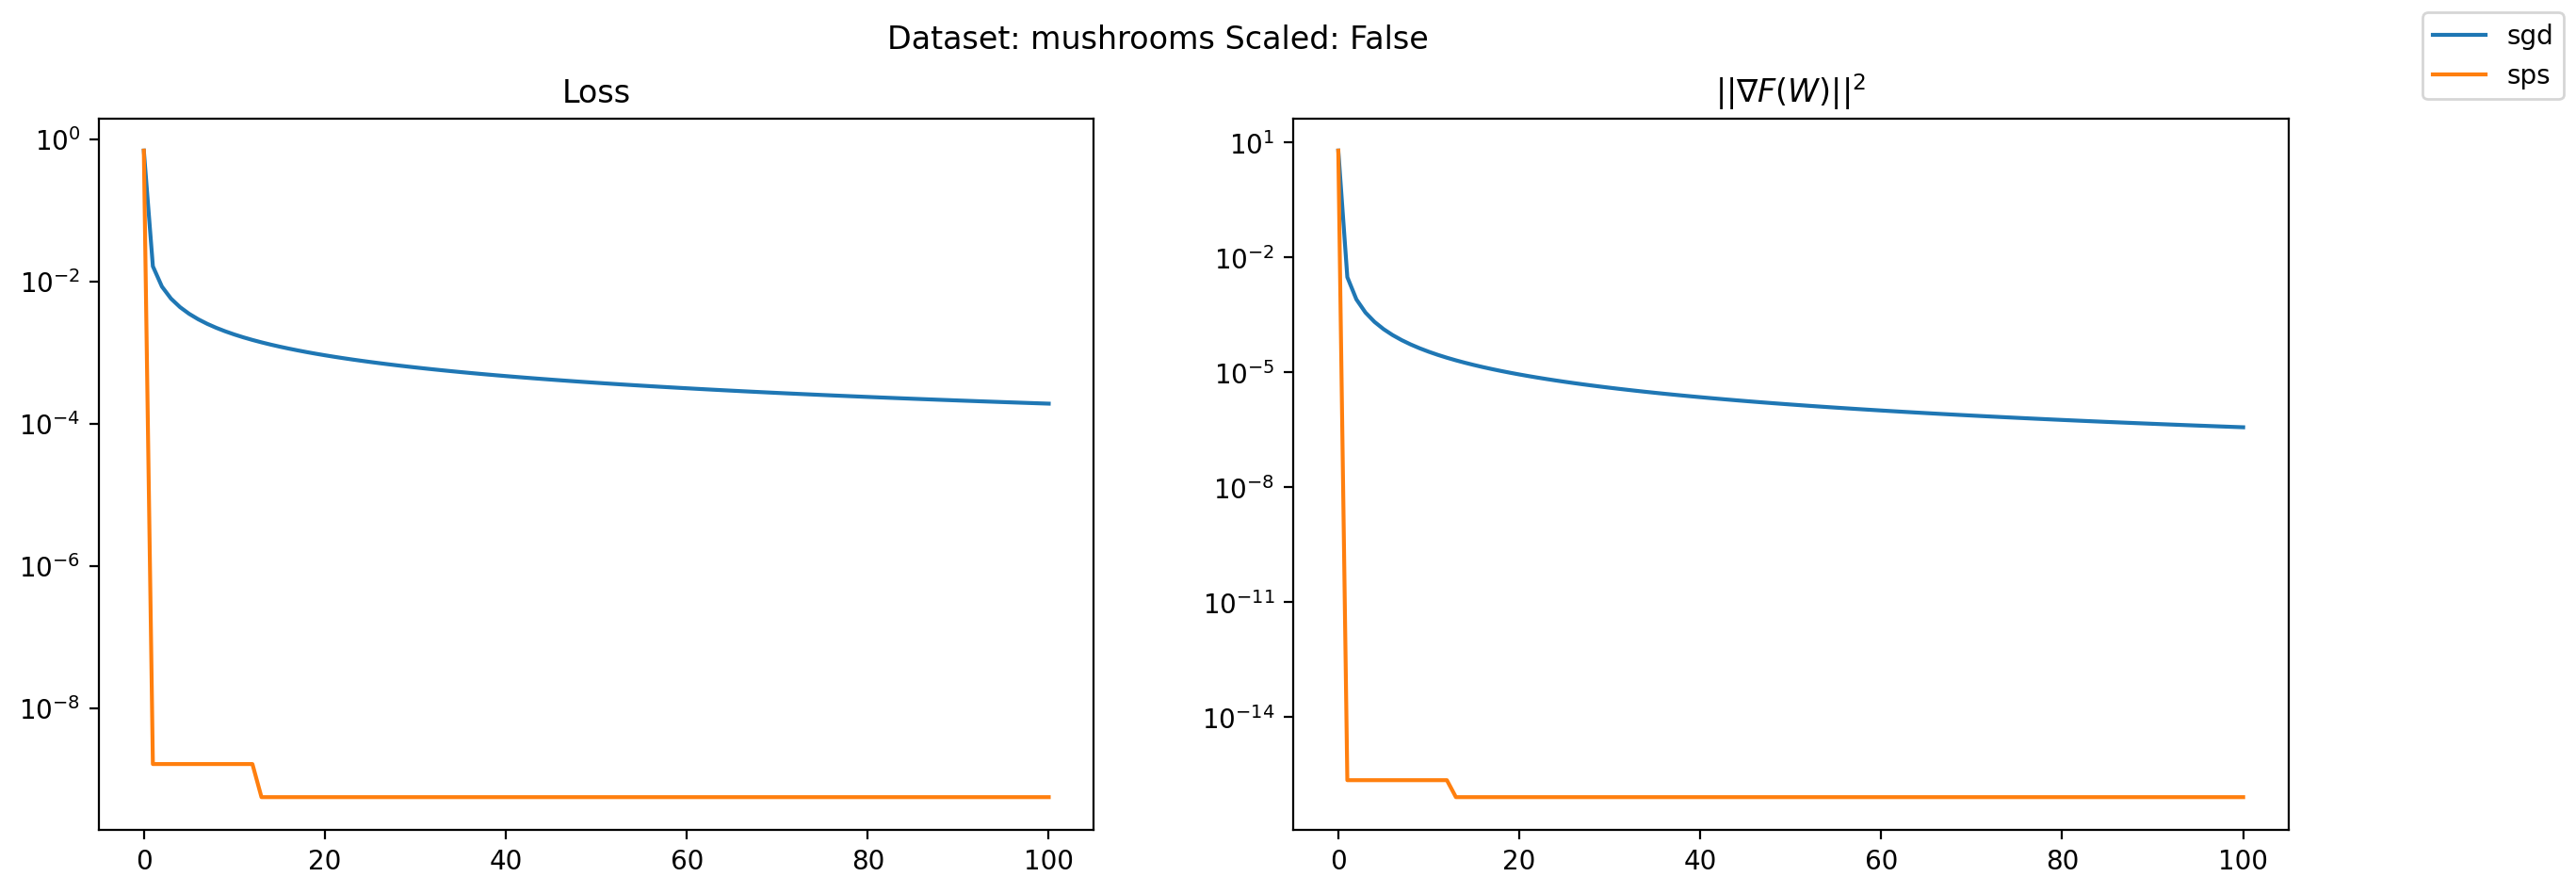

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.semilogy([x[0] for x in sgd])
ax1.semilogy([x[0] for x in sps])
ax1.set_title("Loss")

ax2.semilogy([x[1] for x in sgd])
ax2.semilogy([x[1] for x in sps])
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2$")

fig.suptitle(f"Dataset: {dataset_name} Scaled: {scale_data}")
fig.legend(["sgd", "sps"])

In [47]:
batch_size = 16
dataset_name = "mushrooms"
scale_data = True

train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

sgd = train(
    w,
    LogisticRegression,
    train_data, 
    train_target, 
    batch_size,
    100,
    SGD,
    lr=0.01
)

Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm^2: 0.0
Loss: 0.0 | GradNorm

In [15]:
batch_size = 1
dataset_name = "colon-cancer"
scale_data = True

train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

sps = train(
    LogisticRegression,
    train_data, 
    train_target, 
    batch_size,
    100,
    SPS,
    preconditioner="none",
    slack_method="none"
)

/home/farshed.abdukhakimov/projects/sps2/datasets
Loss: 0.27381277084350586 | GradNorm^2: 2.2847288329785584
Loss: 0.32938632369041443 | GradNorm^2: 3.136483322032646
Loss: 0.3037528097629547 | GradNorm^2: 2.1503056157164337
Loss: 0.319894015789032 | GradNorm^2: 2.79078864456784
Loss: 0.2734363377094269 | GradNorm^2: 2.999035311451067
Loss: 0.17971669137477875 | GradNorm^2: 1.7316037069124377
Loss: 0.22892215847969055 | GradNorm^2: 2.888881205139583
Loss: 0.18794433772563934 | GradNorm^2: 2.80026451697951
Loss: 0.09285978972911835 | GradNorm^2: 1.0260197704747611
Loss: 0.10626530647277832 | GradNorm^2: 1.611787081696093
Loss: 0.07907595485448837 | GradNorm^2: 1.2359385112731616
Loss: 0.06927385181188583 | GradNorm^2: 1.1419481232596809
Loss: 0.05802255496382713 | GradNorm^2: 0.9188966752665237
Loss: 0.056546248495578766 | GradNorm^2: 0.8077902531250061
Loss: 0.03943684324622154 | GradNorm^2: 0.42268339835604607
Loss: 0.04927941784262657 | GradNorm^2: 0.7254534169547391
Loss: 0.05709305

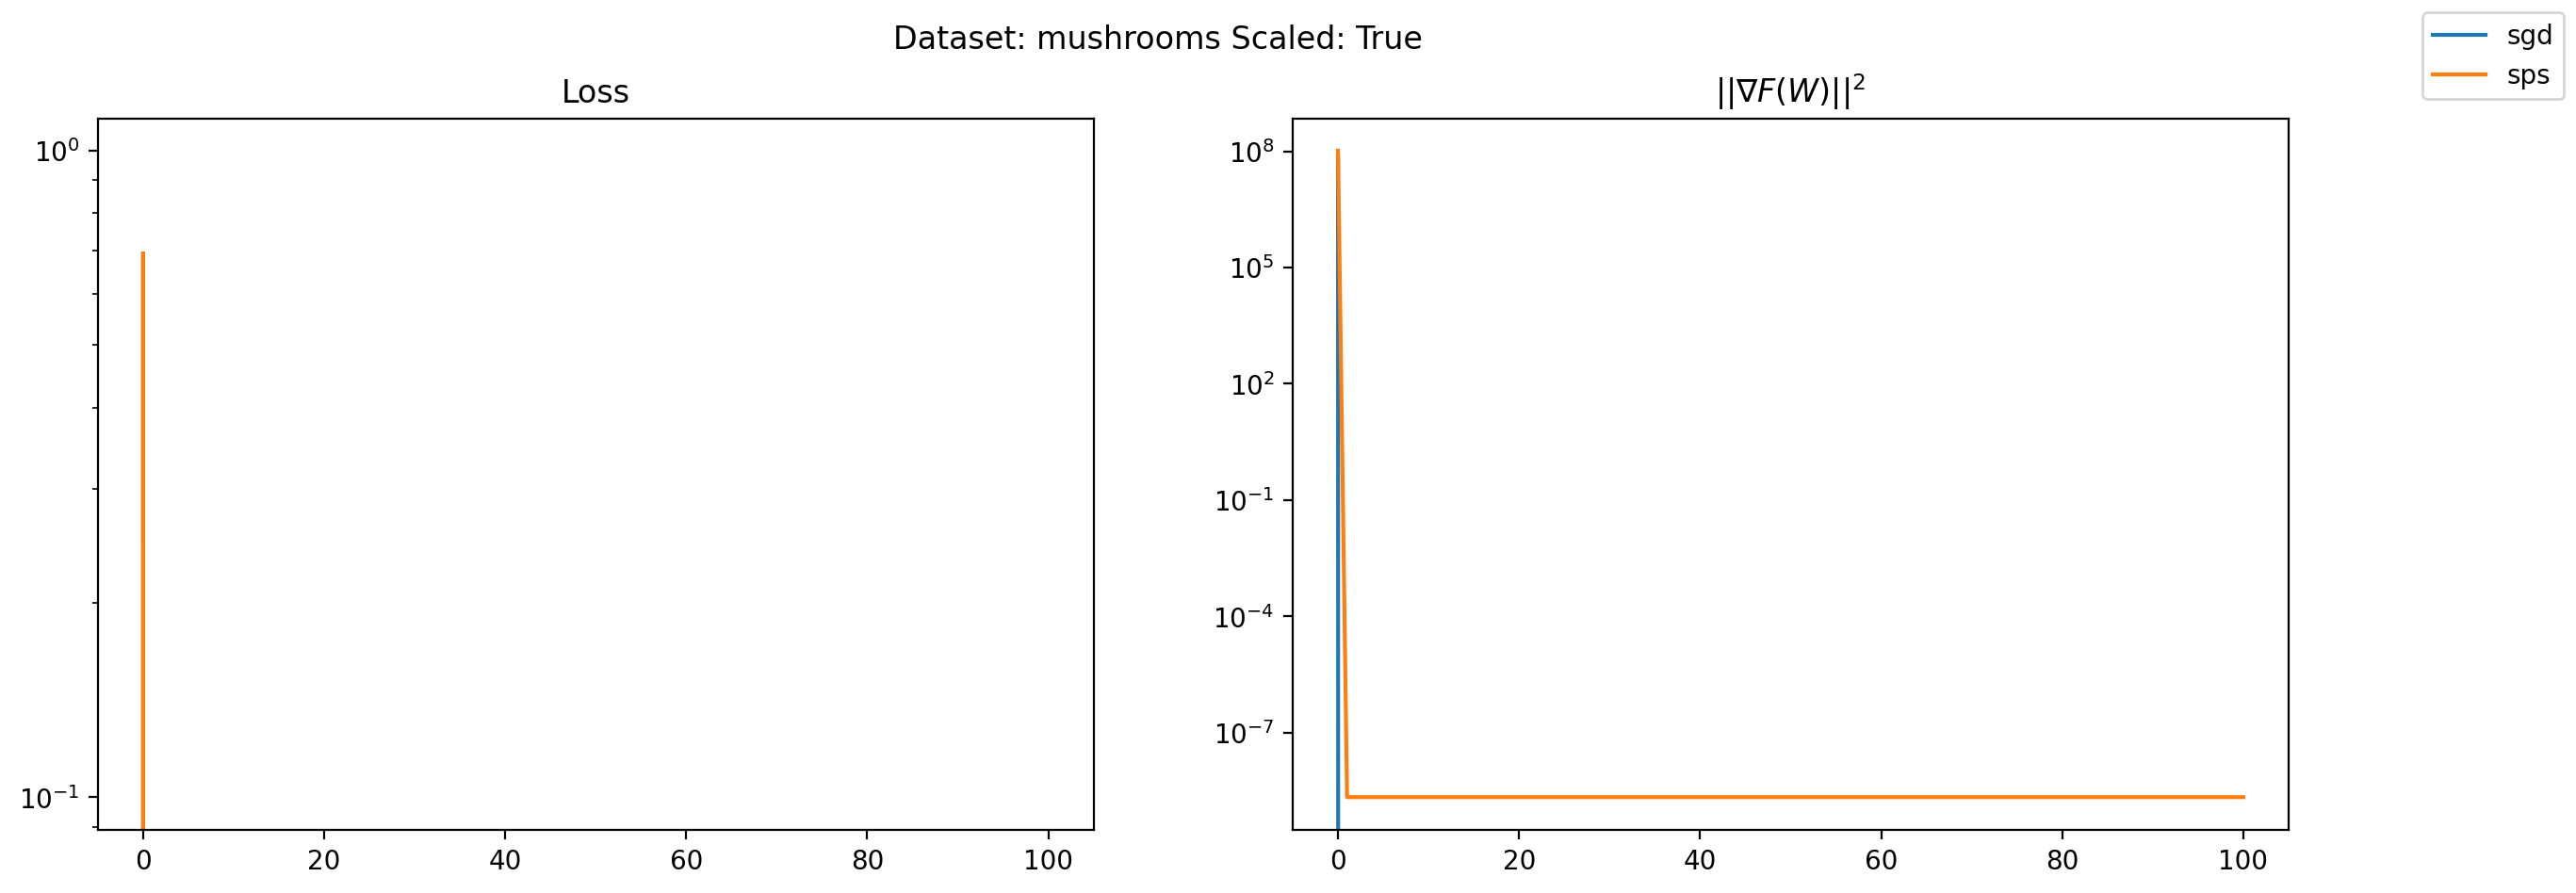

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.semilogy([x[0] for x in sgd])
ax1.semilogy([x[0] for x in sps])
ax1.set_title("Loss")

ax2.semilogy([x[1] for x in sgd])
ax2.semilogy([x[1] for x in sps])
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2$")

fig.suptitle(f"Dataset: {dataset_name} Scaled: {scale_data}")
fig.legend(["sgd", "sps"])

In [9]:
torch.random.manual_seed(0)

torch.manual_seed()

TypeError: manual_seed() missing 1 required positional argument: 'seed'

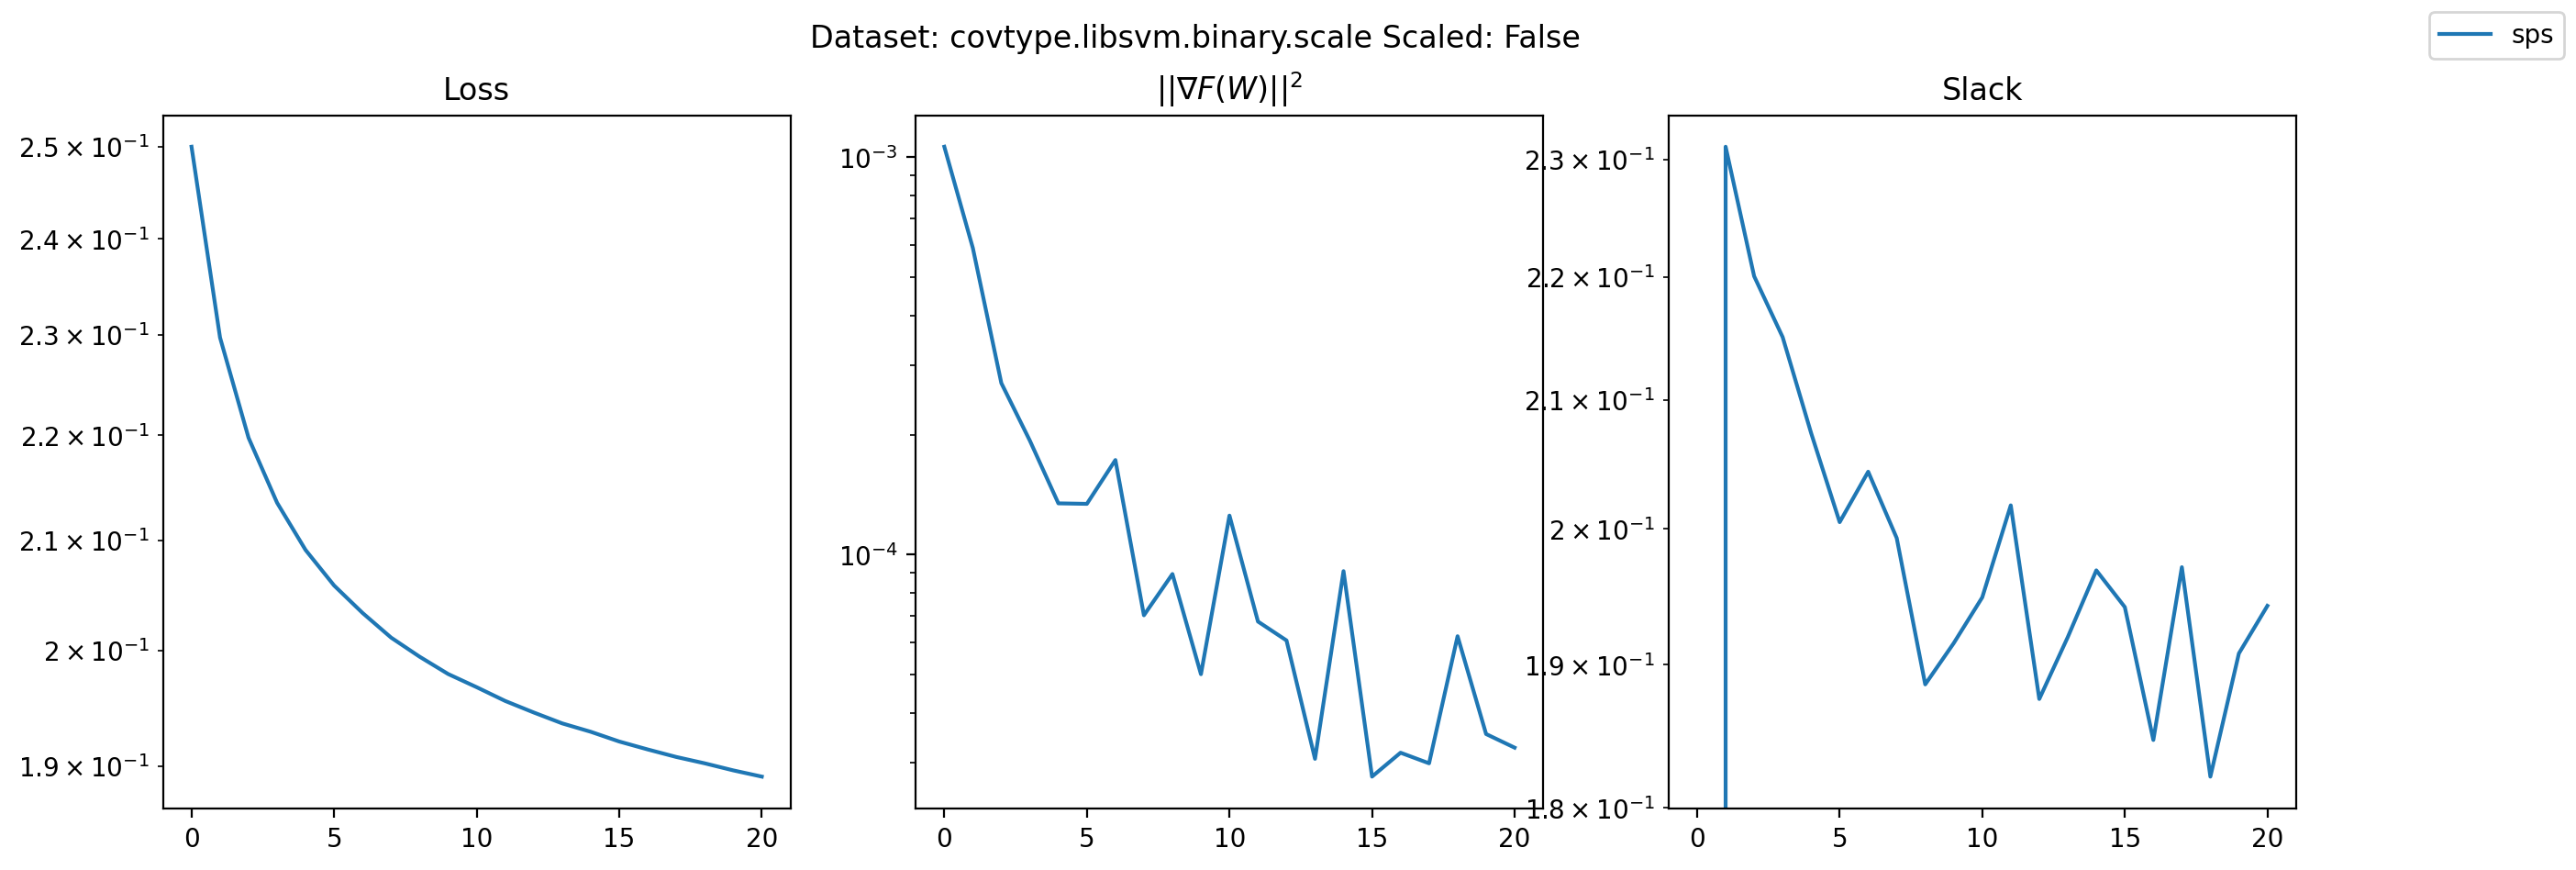

In [13]:
def plotter(dataset, percent, scale, batch_size, 
        epochs, loss_class, optimizer_class, lr, 
        preconditioner, slack_method, lmd, seed):
    
    directory = f"results/{dataset}/percent_{percent}/scaled_{scale}/bs_{batch_size}/epochs_{epochs}/{loss_class}/{optimizer_class}/lr_{lr}/precond_{preconditioner}/slack_{slack_method}/lmd_{lmd}/seed_{seed}"
    losses = torch.load(f"{directory}/loss")
    gnorm_sq = torch.load(f"{directory}/grad_norm_sq")

    if slack_method == "L1" or slack_method == "L2":
        slack = torch.load(f"{directory}/slack")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
    ax[0].semilogy(losses)
    ax[0].set_title("Loss")

    ax[1].semilogy(gnorm_sq)
    ax[1].set_title(r"$\|\| \nabla F(W) \|\|^2$")

    if slack_method == "L1" or slack_method == "L2":
        ax[2].semilogy(slack)
        ax[2].set_title("Slack")

    fig.suptitle(f"Dataset: {dataset} Scaled: {scale}")
    fig.legend([optimizer_class])


plotter(
    "covtype.libsvm.binary.scale",
    0.05, 
    False,
    512,
    20,
    "nllsq",
    "sps",
    0.1,
    "hutch",
    "L1",
    0.05, 
    0
)

In [178]:
from dotenv import load_dotenv

load_dotenv()

True

In [192]:
dataset = "MNIST"
bs = 512
epochs = 1000
loss = "nll_loss"
methods = ["sgd", "adam", "sps"]
lr = 0.1
lmd = 0.1

In [193]:
def get_nn_results(method, dataset=dataset, bs=bs, epochs=epochs, loss=loss, lr=lr, precond="none", slack_method="none", lmd=0.01):
    
    results_dir = os.getenv("RESULTS_DIR")
    directory = f"{results_dir}/smlenet/{dataset}/bs_{bs}/epochs_{epochs}/{loss}/{method}/lr_{lr}/precond_{precond}/slack_{slack_method}/lmd_{lmd}"
    
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    slack = []

    for seed in range(5):
        train_loss.append(torch.load(f"{directory}/seed_{seed}/train_loss"))
        train_acc.append(torch.load(f"{directory}/seed_{seed}/train_acc"))
        test_loss.append(torch.load(f"{directory}/seed_{seed}/test_loss"))
        test_acc.append(torch.load(f"{directory}/seed_{seed}/test_acc"))
        if slack_method != "none":
            slack.append(torch.load(f"{directory}/seed_{seed}/slack"))
    
    return {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "slack": slack
    }

In [194]:
def get_label(precond, slack):
    if precond == "none":
        if slack == "none":
            return "SPS"
        else:
            return f"SPS{slack}"
    else:
        if slack == "none":
            return "PSPS"
        else:
            return f"PSPS{slack}"

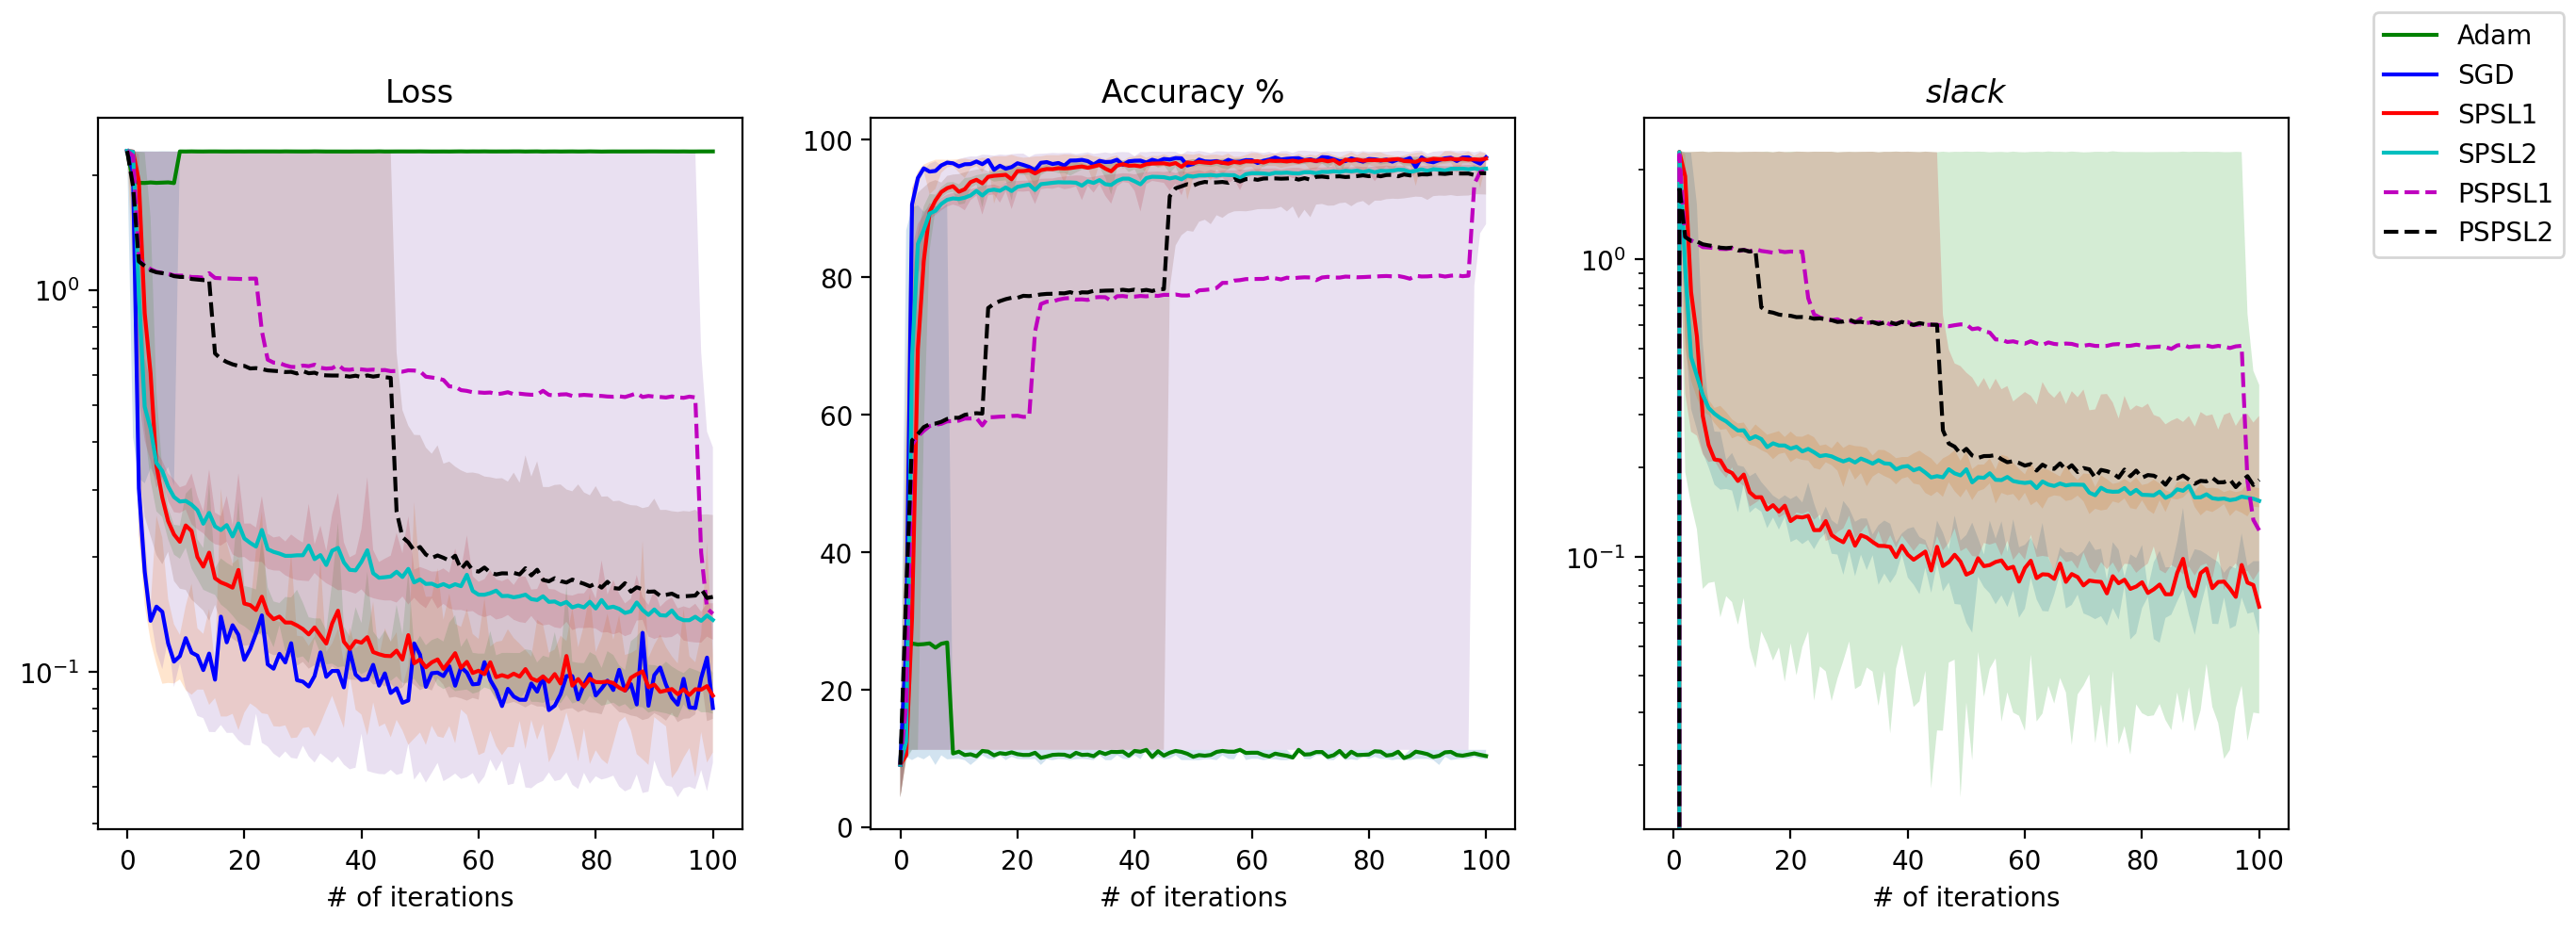

In [206]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

x = np.linspace(0, 100, 101)
LMD = 0.1

colors = {
    "sgd": "b",
    "adam": "g",
    "L1_none": "r",
    "L2_none": "c",
    "L1_hutch": "m",
    "L2_hutch": "black"
}

# LOSS
for method in ["adam", "sgd"]:
    res = get_nn_results(method)["train_loss"]
    mean_line = np.mean(res, axis=0)
    max_line = np.max(res, axis=0)
    min_line = np.min(res, axis=0)

    if method == "adam":
        label = "Adam"
    else:
        label = "SGD"


    ax[0].fill_between(x, max_line, min_line, alpha=0.2)
    ax[0].semilogy(x, mean_line, color=colors[method], label=label)



for precond in ["none", "hutch"]:
    for slack in ["L1", "L2"]:
        lmd = 0.01
        if slack != "none":
            lmd = LMD

        res = get_nn_results("sps", precond=precond, slack_method=slack, lmd=lmd)["train_loss"]
        mean_line = np.mean(res, axis=0)
        max_line = np.max(res, axis=0)
        min_line = np.min(res, axis=0)

        if precond == "hutch":
            linestyle = "--"
        else:
            linestyle = "-"

        label = get_label(precond, slack)

        ax[0].fill_between(x, max_line, min_line, alpha=0.2) 
        ax[0].semilogy(x, mean_line, color=colors[f"{slack}_{precond}"], linestyle=linestyle, label=label)
        ax[0].set_title("Loss")
        ax[0].set_xlabel("# of iterations")
        


# ACC
for method in ["adam", "sgd"]:
    res = get_nn_results(method)["train_acc"]
    mean_line = np.mean(res, axis=0)
    max_line = np.max(res, axis=0)
    min_line = np.min(res, axis=0)

    ax[1].fill_between(x, max_line, min_line, alpha=0.2)
    ax[1].plot(x, mean_line, color=colors[method])
    ax[1].set_title("Accuracy %")
    ax[1].set_xlabel("# of iterations")



for precond in ["none", "hutch"]:
    for slack in ["L1", "L2"]:
        lmd = 0.01
        if slack != "none":
            lmd = LMD

        res = get_nn_results("sps", precond=precond, slack_method=slack, lmd=lmd)["train_acc"]
        mean_line = np.mean(res, axis=0)
        max_line = np.max(res, axis=0)
        min_line = np.min(res, axis=0)

        if precond == "hutch":
            linestyle = "--"
        else:
            linestyle = "-"
        
        ax[1].fill_between(x, max_line, min_line, alpha=0.2) 
        ax[1].plot(x, mean_line, color=colors[f"{slack}_{precond}"], linestyle=linestyle)

#SLACK
for precond in ["none", "hutch"]:
    for slack in ["L1", "L2"]:
        lmd= LMD
        res = get_nn_results("sps", precond=precond, slack_method=slack, lmd=lmd)["slack"]
        mean_line = np.mean(res, axis=0)
        max_line = np.max(res, axis=0)
        min_line = np.min(res, axis=0)

        if precond == "hutch":
            linestyle = "--"
        else:
            linestyle = "-"
        
        ax[2].fill_between(x, max_line, min_line, alpha=0.2) 
        ax[2].semilogy(x, mean_line, color=colors[f"{slack}_{precond}"], linestyle=linestyle)     
        ax[2].set_title(r"$slack$") 
        ax[2].set_xlabel("# of iterations")
 


# fig.suptitle(f"Dataset: MNIST")
# fig.legend(["adam", "sgd", "sps_l1", "sps_l2", "sps_l1_d", "sps_l2_d"])
fig.legend()

fig.savefig(f"new_plots/{dataset}_SmallLeNet_lmd-{LMD}.png")
